In [1]:
import numpy as np
import pandas as pd

In [2]:
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
import re,string,unicodedata
from bs4 import BeautifulSoup

In [17]:
df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)

In [18]:
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [19]:
# Cleaning text for only Column - > context
def clean_text(text):
       
    # Convert sentence to lowercase
    text = text.lower()

    # Remove all punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Remove Apostrophe & Full-Stop
    if "'" in text:
        text = text.replace("'", "")
    if "." in text:
        text = text.replace(".", "")

    # Remove all digits
    text = re.sub(r"\d+", "", text)

    # Remove all extra whitespace
    text = re.sub(r"\s+", " ", text).strip()

    # Remove all stop words (optional)
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

In [20]:
df = df.drop(['article_link'], axis = 1)
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [44]:
df['headline'] = df['headline'].apply(clean_text)

In [45]:
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientist unveil doomsday cloc...
1,0,dem rep totally nail congress fall short gende...
2,0,eat veggie deliciously different recipe
3,1,inclement weather prevents liar get work
4,1,mother come pretty close use word stream corre...


In [46]:
# Lemmatization

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

# initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# define function to map POS tag to WordNet POS tag
def get_wordnet_pos(word):
    """Map POS tag to WordNet POS tag"""
    tag = nltk.pos_tag([word])[0][1]
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# define function to perform lemmatization on a sentence of CONTEXT & UTTERANCES
def lemmatization(sentence):

    # tokenize each sentence in cell
    tokens = sentence.split(" ")

    # lemmatize each tokens
    lemmatized_list_of_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]

    # join to form sentence
    res = ' '.join([word for word in lemmatized_list_of_tokens])
   
    return res


In [47]:
df['headline'] = df['headline'].apply(lemmatization)
df['headline'] = df['headline'].apply(clean_text)
df['headline'] = df['headline'].apply(lemmatization)

In [48]:
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientist unveil doomsday cloc...
1,0,dem rep totally nail congress fall short gende...
2,0,eat veggie deliciously different recipe
3,1,inclement weather prevents liar get work
4,1,mother come pretty close use word stream corre...


In [49]:
df.to_csv('Processed_headline_data.csv')

In [50]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [51]:
#create dependent and independent variables
sentences = []
labels = []

sentences = df['headline'].values
labels = df['is_sarcastic'].values

In [52]:
tokenizer = Tokenizer(oov_token = "<OOV>")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

In [53]:
list(word_index.keys())[:10]

['<OOV>', 'trump', 'new', 'man', 'get', 'woman', 'make', 'say', 'report', 'u']

In [54]:
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences,padding = 'post')

In [55]:
sequences[0]

[12095, 267, 2454, 5237, 2128, 615, 1010]

In [56]:
padded

array([[12095,   267,  2454, ...,     0,     0,     0],
       [ 6002,  1398,   688, ...,     0,     0,     0],
       [  223,  7125, 12096, ...,     0,     0,     0],
       ...,
       [  562,  2830,   271, ...,     0,     0,     0],
       [ 1412,   975,  2880, ...,     0,     0,     0],
       [  117,  2861,   200, ...,     0,     0,     0]])

In [57]:
print(padded[0])
print(padded.shape)

[12095   267  2454  5237  2128   615  1010     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0]
(28619, 106)


In [58]:
#after looking up on raw data tokens , sequences lets move forward to create training and testing dataset. Henceforth applying neural network
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


In [59]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [60]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [61]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [62]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [63]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [64]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 7s - loss: 0.6887 - accuracy: 0.5354 - val_loss: 0.6746 - val_accuracy: 0.6678 - 7s/epoch - 11ms/step
Epoch 2/30
625/625 - 5s - loss: 0.5813 - accuracy: 0.7310 - val_loss: 0.4957 - val_accuracy: 0.7761 - 5s/epoch - 7ms/step
Epoch 3/30
625/625 - 5s - loss: 0.4219 - accuracy: 0.8177 - val_loss: 0.4559 - val_accuracy: 0.7780 - 5s/epoch - 8ms/step
Epoch 4/30
625/625 - 5s - loss: 0.3513 - accuracy: 0.8498 - val_loss: 0.4302 - val_accuracy: 0.8044 - 5s/epoch - 8ms/step
Epoch 5/30
625/625 - 5s - loss: 0.3121 - accuracy: 0.8694 - val_loss: 0.4303 - val_accuracy: 0.8051 - 5s/epoch - 7ms/step
Epoch 6/30
625/625 - 5s - loss: 0.2813 - accuracy: 0.8827 - val_loss: 0.4593 - val_accuracy: 0.7864 - 5s/epoch - 8ms/step
Epoch 7/30
625/625 - 5s - loss: 0.2591 - accuracy: 0.8937 - val_loss: 0.4578 - val_accuracy: 0.8038 - 5s/epoch - 8ms/step
Epoch 8/30
625/625 - 5s - loss: 0.2397 - accuracy: 0.9031 - val_loss: 0.4689 - val_accuracy: 0.8037 - 5s/epoch - 8ms/step
Epoch 9/30
625/625 - 5s

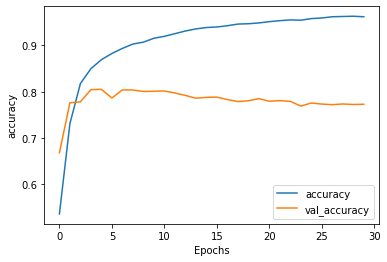

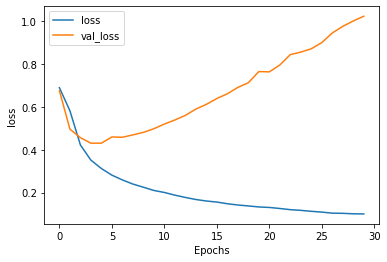

In [65]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [66]:
pred = (model.predict(testing_padded) > 0.5).astype("int32")

270/270 [==============================] - 1s 3ms/step


In [67]:
from sklearn.metrics import classification_report

print(classification_report(testing_labels,pred,target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.78      0.79      0.79      4524
    Sarcastic       0.77      0.75      0.76      4095

     accuracy                           0.77      8619
    macro avg       0.77      0.77      0.77      8619
 weighted avg       0.77      0.77      0.77      8619



In [69]:
keras.models.save_model(model, "sarcasm_preprocessed_model.h5")